In [1]:
#import theano 
from scipy.integrate import odeint
import math 
import numpy as np
import theano 
from theano import *
import matplotlib.pyplot as plt

%matplotlib inline

theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity= 'high'
THEANO_FLAGS='floatX=float64,optimizer=fast_compile'

#  Forward model using scipy odeint

In this example we'll use a model of a reversible chemical reaction:

$$\dot{y}(t) = k_1 (1 - y) - k_2 y,$$

where $k_1$ represents a forward reaction rate, $k_2$ is the backward reaction rate, and $y$ represents the concentration of a chemical solute.

Next, we write a Python function `r` that represents the right-hand side of this ODE, choose a set of parameters and initial conditions, and solve using SciPy.

In [2]:
def model_deriv(y, t, param):
    #Define parameters
    k1,k2=param
    #print(param)
    #define states
    #V,dV_da,dV_db=y
    Y,dY_dk1,dY_dk2=y
    #define derivatives
    dy_dt=k1 * (1 - Y) - k2 * Y
    #define sensitivity odes
    dy_dk1_dt=-(k1+k2)*dY_dk1 + (1-Y)
    dy_dk2_dt=-(k1+k2)*dY_dk2 - Y
    
    
    return dy_dt,dy_dk1_dt,dy_dk2_dt

def model_sol(param):
    
    y0 = [0.1,0,0]
    time = np.linspace(0, 2, 40)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

#  Generate an artificial dataset

We add random noise $\mathcal{N}(0,0.05)$ to the ODE solution to generate the artificial dataset.

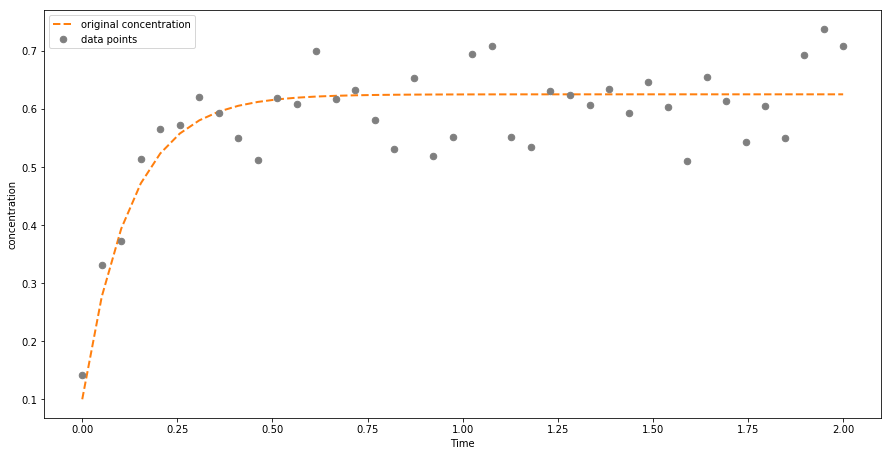

In [3]:
times = np.linspace(0, 2, 40)
sol=model_sol([5.,3.])
true_sol=sol[:,0]
sigma=0.05
Y=true_sol + np.random.randn(40)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, true_sol, '--', color='#ff7f0e', lw=2, label='original concentration')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')

#  Define a custom Theano op with grad 

This op that we define here is model (ODE) agnostic. It can be used for any ODE system, so it is like boilerplate code.


In [4]:
class ODEop(theano.Op):

    def __init__(self, state, jac_sens):
        self.state = state
        self.jac_sens = jac_sens

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self.state(x))

    def grad(self, inputs, output_grads):

        x = inputs[0]
        v = output_grads[0]

        op = self

        class ODEGradop(theano.Op):
            def __init__(self):
                pass

            def make_node(self, x, v):
                x = theano.tensor.as_tensor_variable(x)
                v = theano.tensor.as_tensor_variable(v)
                node = theano.Apply(self, [x, v], [v.type()])
                return node

            def perform(self, node, inputs_storage, output_storage):
                x = inputs_storage[0]
                v = inputs_storage[1]
                out = output_storage[0]
                out[0] = np.asarray(op.jac_sens(x, v))

        grad_op = ODEGradop()
        grad_op_apply = grad_op(x, v)
        
        #grad = theano.dot(theano.tensor.transpose(grad_op_apply),v)
        return [grad_op_apply]

#  Define functions that collects the ODE state and sensitivity  

The following two functions calls the forward model (scipy odeint) and passes the state and vector-jacobian product as part of the backprop algorithm. This functions are then called within our new Theano op.


In [5]:
def state(x):
    sol = model_sol(np.array(x))
    return sol[:,0]
def jac_sens(x, v):
    sol = model_sol(np.array(x))
    return sol[:,-2:].T.dot(v)


#  Define the probabilistic program

Next we define the PyMC3 model and call the fullrank ADVI method and press the inference button. 

In [18]:
import pymc3 as pm
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'
#theano.config.device='cpu'
my_op = ODEop(state, jac_sens)

with pm.Model() as model:
    # We place Gamma priors on the two model parameters
    theta = pm.Gamma('theta', alpha=2, beta=1, shape=2)
    
    # Here we call the forward model
    forward=my_op(theta)
    
    # We place Half-Normal prior on the noise parameter
    sigma = pm.HalfNormal('sigma', sd=0.1)
    
    # The likelihood is Gaussian
    y=pm.Normal('y', mu=forward, sd=sigma, observed=Y)
    #start={'theta':np.array([0.1,4.])}
    #trace = pm.sample(5000)
    
    # Now we carry out the variational inference and save the fullrank approximation
    fullrank = pm.fit(20000,method='fullrank_advi')

Average Loss = -49.143: 100%|███████████████████████████████████████████████████| 20000/20000 [01:08<00:00, 292.86it/s]
Finished [100%]: Average Loss = -49.142


#  Visualising the posterior approximation

Its easy to draw samples from the variational density $q(\theta)$. 

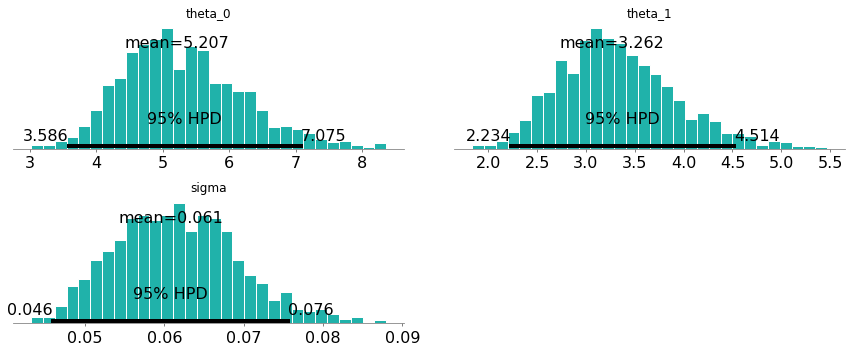

In [19]:
pm.plot_posterior(fullrank.sample(1000), color='LightSeaGreen');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E46EAC73C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E46F902630>]], dtype=object)

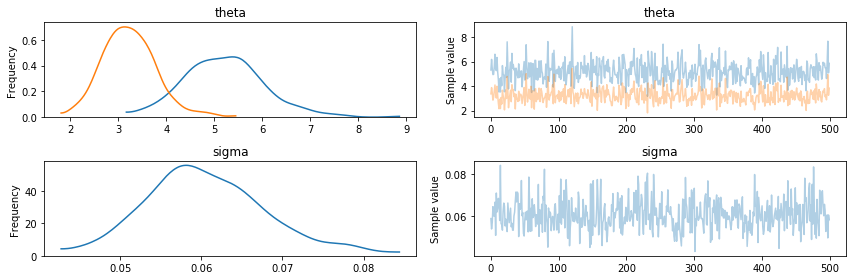

In [16]:
samples=fullrank.sample(500)
pm.traceplot(samples)

#  Posterior predictive plots

Draw $500$ samples of the state as the posterior predictive

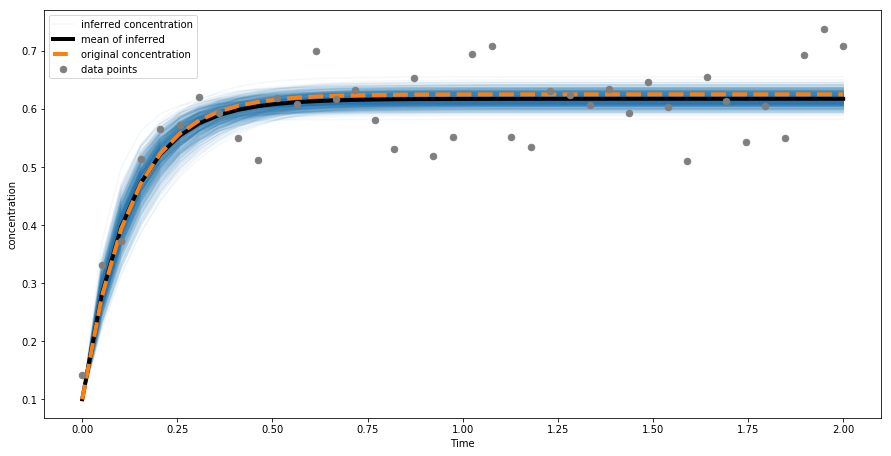

In [17]:
params=samples['theta']
params.shape
new_values = []
for ind in range(500):
    ppc_sol=model_sol(params[ind])
    new_values.append(ppc_sol[:,0])
new_values = np.array(new_values)
mean_values = np.mean(new_values, axis=0)
new_values.shape
plt.figure(figsize=(15, 7.5))
plt.plot(times, new_values[0], color='#1f77b4', alpha=0.05, label='inferred concentration')
for v in new_values[1:]:
    plt.plot(times, v, color='#1f77b4', alpha=0.05)
plt.plot(times, mean_values, color='black', lw=4, label='mean of inferred')
plt.plot(times, true_sol, '--', color='#ff7f0e', lw=4, label='original concentration')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')
